In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

In [14]:
# Step 1: Load Dataset
image_size = (180, 180)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    "food_6",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "food_6",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

Found 400 files belonging to 4 classes.
Using 320 files for training.
Found 400 files belonging to 4 classes.
Using 80 files for validation.


In [15]:
#  Capture class names before prefetching
class_names = train_ds.class_names
num_classes = len(class_names)

# Step 2: Prefetch Datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
# Step 3: Load Base Model (No Fine-Tuning)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=image_size + (3,)
)
base_model.trainable = False  # Freeze all layers

In [17]:
# Step 4: Add Classification Head
inputs = tf.keras.Input(shape=image_size + (3,))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)  # keep batch norm in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [18]:
# Step 5: Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 6: Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2520 - loss: 1.9900 - val_accuracy: 0.4625 - val_loss: 1.3144
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 948ms/step - accuracy: 0.3712 - loss: 1.4857 - val_accuracy: 0.4750 - val_loss: 1.1949
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4064 - loss: 1.4046 - val_accuracy: 0.5750 - val_loss: 1.0385
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 862ms/step - accuracy: 0.5243 - loss: 1.2219 - val_accuracy: 0.6250 - val_loss: 0.9351
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5487 - loss: 1.1033 - val_accuracy: 0.6375 - val_loss: 0.8479
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 930ms/step - accuracy: 0.5448 - loss: 1.0534 - val_accuracy: 0.7125 - val_loss: 0.7705
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 802ms/step - accuracy: 0.5475 - loss: 1.0290 - val_accuracy: 0.7625 - val_loss: 0.6995
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 950ms/step - accuracy: 0.6507 - loss: 0.8460 - val_accuracy: 0.7

In [19]:
# Step 7: Save Model
model.save("resnet_model.keras")

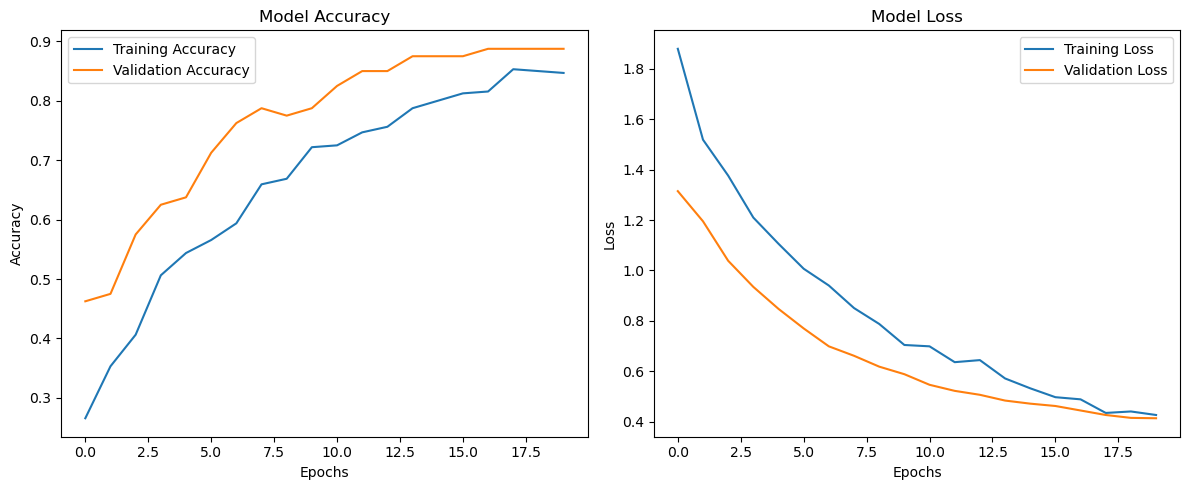

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
axs[0].plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training Accuracy")
axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation Accuracy")
axs[0].set_title("Model Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot Loss
axs[1].plot(range(len(history.history["loss"])), history.history["loss"], label="Training Loss")
axs[1].plot(range(len(history.history["val_loss"])), history.history["val_loss"], label="Validation Loss")
axs[1].set_title("Model Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()